In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import glob
import torchvision.io
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
class LipReadingDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, fixed_frame_count=29, max_classes=500):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))[:max_classes]
        self.files = []
        self.fixed_frame_count = fixed_frame_count
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls, phase)
            for file in os.listdir(class_dir):
                if file.endswith('.mp4'):
                    self.files.append((os.path.join(class_dir, file), cls))
        
        print(f"Found {len(self.files)} videos across {len(self.classes)} classes.")
        if len(self.files) == 0:
            print("No videos found. Please check the dataset directory structure and paths.")
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        video_path, label = self.files[idx]
        frames = self.load_video(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        label = self.classes.index(label)
        frames = torch.stack(frames)
        
        return frames, label
    
    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release()
        return frames

In [3]:
# Function to split the dataset
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

# Function to get predictions and true labels
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            accuracy = accuracy_score(all_labels, all_preds)

    return accuracy, all_preds, all_labels

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

def plot_loss(train_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
    
def plot_acc(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plot')
    plt.legend()
    plt.grid(True)

    plt.show()

In [4]:
def collate_fn(batch):
    videos, labels = zip(*batch)
    padded_videos = []
    for video in videos:
        resized_video = torch.stack([resize(frame, (128, 128)) for frame in video])
        padded_videos.append(resized_video[5:25])

    return torch.stack(padded_videos), torch.tensor(labels)

In [5]:
# Path to the processed_selected_mp4_files directory
root_dir = '/kaggle/input/processed-25-lrw/preprocessed_25'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_val_dataset = LipReadingDataset(root_dir, 'train', transform=transform, max_classes=25)
train_dataset, val_dataset = split_dataset(train_val_dataset, train_ratio=0.8)
test_dataset = LipReadingDataset(root_dir, 'test', transform=transform, max_classes=25)

cuda:0
Found 5000 videos across 25 classes.
Found 1225 videos across 25 classes.


In [18]:
class LipReadingModel(nn.Module):
    def __init__(self, num_classes):
        super(LipReadingModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(64*32*32, 256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size, seq_len, -1)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_loss = []
    val_acc = []
    train_acc = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        all_labels = []
        all_preds = []

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        avg_loss = epoch_loss / len(train_loader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracy, _, _ = evaluate_model(model, val_loader, device)

        train_loss.append(avg_loss)
        val_acc.append(val_accuracy)
        train_acc.append(train_accuracy)

        scheduler.step()
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
    return train_loss, train_acc, val_acc

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=lambda x: collate_fn(x))
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=lambda x: collate_fn(x))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x))

num_classes = len(train_val_dataset.classes)  # Automatically get the number of classes
learning_rate = 0.0001
num_epochs = 20

model = LipReadingModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_loss, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000099, Epoch [1/20], Avg Loss: 3.2377, Train Accuracy: 0.0357, Validation Accuracy: 0.0440


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 2/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000098, Epoch [2/20], Avg Loss: 3.2218, Train Accuracy: 0.0400, Validation Accuracy: 0.0390


Epoch 3/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000095, Epoch [3/20], Avg Loss: 3.2125, Train Accuracy: 0.0462, Validation Accuracy: 0.0550


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 4/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000090, Epoch [4/20], Avg Loss: 3.1821, Train Accuracy: 0.0643, Validation Accuracy: 0.0510


Epoch 5/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000085, Epoch [5/20], Avg Loss: 3.0928, Train Accuracy: 0.1027, Validation Accuracy: 0.0670


Epoch 6/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000079, Epoch [6/20], Avg Loss: 2.9691, Train Accuracy: 0.1507, Validation Accuracy: 0.0780


Epoch 7/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000073, Epoch [7/20], Avg Loss: 2.8247, Train Accuracy: 0.2005, Validation Accuracy: 0.0890


Epoch 8/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000065, Epoch [8/20], Avg Loss: 2.6690, Train Accuracy: 0.2615, Validation Accuracy: 0.1000


Epoch 9/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000058, Epoch [9/20], Avg Loss: 2.5042, Train Accuracy: 0.3240, Validation Accuracy: 0.1110


Epoch 10/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000050, Epoch [10/20], Avg Loss: 2.3266, Train Accuracy: 0.3892, Validation Accuracy: 0.1120


Epoch 11/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000042, Epoch [11/20], Avg Loss: 2.1578, Train Accuracy: 0.4637, Validation Accuracy: 0.1230


Epoch 12/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000035, Epoch [12/20], Avg Loss: 1.9980, Train Accuracy: 0.5340, Validation Accuracy: 0.1170


Epoch 13/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000027, Epoch [13/20], Avg Loss: 1.8540, Train Accuracy: 0.5895, Validation Accuracy: 0.1220


Epoch 14/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000021, Epoch [14/20], Avg Loss: 1.7271, Train Accuracy: 0.6482, Validation Accuracy: 0.1280


Epoch 15/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000015, Epoch [15/20], Avg Loss: 1.6167, Train Accuracy: 0.6945, Validation Accuracy: 0.1310


Epoch 16/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000010, Epoch [16/20], Avg Loss: 1.5309, Train Accuracy: 0.7238, Validation Accuracy: 0.1350


Epoch 17/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000005, Epoch [17/20], Avg Loss: 1.4671, Train Accuracy: 0.7535, Validation Accuracy: 0.1360


Epoch 18/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000002, Epoch [18/20], Avg Loss: 1.4218, Train Accuracy: 0.7690, Validation Accuracy: 0.1380


Epoch 19/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Learning Rate: 0.000001, Epoch [19/20], Avg Loss: 1.3948, Train Accuracy: 0.7795, Validation Accuracy: 0.1380


Epoch 20/20:   0%|          | 0/400 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


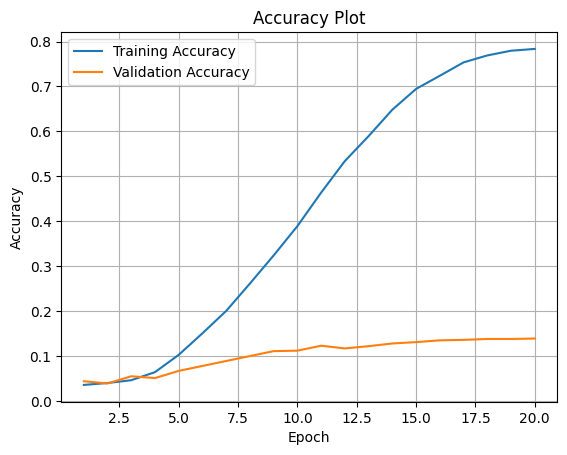

In [22]:
plot_acc(train_acc, val_acc)